# Kritias

## 1. Finding the point where ChatGPT took over

### 1.1 Text Preprocessing

In [83]:
# imports
import re  # regular expressions
import nltk  # for stemming
import numpy as np  # for matrices
import matplotlib.pyplot as plt  # for graphs

In [84]:
# load files
f_kritias = open('Kritias.txt', 'r')
#f_timaeus = open('Timaeus.txt', 'r')
f_stop_words = open('smart.txt', 'r')  # from exercise sheet 09

In [85]:
# methods to process words from abstract analogous to exercise sheet 09

def tidy_and_stem(words):
    # remove '\'
    words = [word.replace('\'', '') for word in words]
    # remove non-alphabetic characters
    words = [word for word in words if word.isalpha()]
    # stem
    ps = nltk.stem.PorterStemmer()
    return [ps.stem(word) for word in words]

def get_preprocessed_words(abstract, stop_words):
    # select characters to separate 
    abstract = re.sub(r'\s+|[.,:;!?()\"-]+', ' ', abstract)
    words = abstract.split()
    words = tidy_and_stem(words)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # remove empty strings if there are any
    words = [word for word in words if word]
    return words

In [86]:
stop_words = tidy_and_stem(f_stop_words.read().lower().split())

In [87]:
kriti_sntncs = f_kritias.read().lower().split('.')

### 1.2 Term-Sentence Matrix

In [88]:
# find unique terms
# also save cleaned sentences
unique_terms_set = set()
cleaned_sntncs = []
for sentence in kriti_sntncs:
    clean_sntnc = ""
    for term in get_preprocessed_words(sentence, stop_words):
        unique_terms_set.add(term)
        clean_sntnc = clean_sntnc + " " + term
    cleaned_sntncs.append(clean_sntnc)
unique_terms = list(unique_terms_set)
len(cleaned_sntncs)

192

In [89]:
len(unique_terms)

1107

In [90]:
kriti_sntncs[0]

'timaeus: how thankful i am, socrates, that i have arrived at last, and, like a weary traveller after a long journey, may be at rest! and i pray the being who always was of old, and has now been by me revealed, to grant that my words may endure in so far as they have been spoken truly and acceptably to him; but if unintentionally i have said anything wrong, i pray that he will impose upon me a just retribution, and the just retribution of him who errs is that he should be set right'

In [91]:
cleaned_sntncs[0]

' timaeu socrat arriv weari travel long journey rest pray reveal grant word endur spoken accept unintent wrong pray impos retribut retribut err set'

In [92]:
unique_terms[0:10]

['afford',
 'power',
 'archer',
 'state',
 'feet',
 'naval',
 'govern',
 'parn',
 'recount',
 'daybreak']

In [93]:
'atlantis' in unique_terms

False

In [94]:
'atlanti' in unique_terms

True

In [95]:
'atlant' in unique_terms

True

In [96]:
'atlan' in unique_terms

False

In [97]:
'atla' in unique_terms

True

In [98]:
cleaned_sntncs[0:3]

[' timaeu socrat arriv weari travel long journey rest pray reveal grant word endur spoken accept unintent wrong pray impos retribut retribut err set',
 ' speak futur gener god pray knowledg medicin perfect',
 ' offer prayer deliv argument critia speak agreement']

In [99]:
# create term-sentence matrix (which is a term-document matrix where the documents are sentences)
m = len(unique_terms)
n = len(cleaned_sntncs)
term_sntnc_matrix = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        sntnc = cleaned_sntncs[j]
        term_sntnc_matrix[i][j] = sntnc.count(unique_terms[i])

In [100]:
np.set_printoptions(threshold=np.inf)
A = np.asmatrix(term_sntnc_matrix)
A

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

In [101]:
np.set_printoptions(threshold=1000)
A

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [102]:
np.shape(A)
# rows: terms
# cols: sentences

(1107, 192)

In [103]:
np.sum(A)

3221.0

In [104]:
np.sum(A) / 192

16.776041666666668

### 1.3 Try to find term discrepancy in halves

In [105]:
# we don't know where ChatGPT took over, but we know that the first half
# of the text has a bigger percentage of original words than the second
half = len(cleaned_sntncs)//2
first_half = cleaned_sntncs[:half]
second_half = cleaned_sntncs[half:]

# count terms
def cnt_term(sentences, term):
    return sum(1 for sntnc in sentences if term in re.findall(r'\b\w+\b', sntnc))
    
def cnt_all_terms(sentences):
    return [cnt_term(sentences, term) for term in unique_terms]
    
term_cnt_first = cnt_all_terms(first_half)
term_cnt_second = cnt_all_terms(second_half)

# find words that appeared at least twice as often in the second half and at least 5 times
second_half_terms = [
    term for term, count_first, count_second in zip(unique_terms, term_cnt_first, term_cnt_second)
    if count_second >= 2 * count_first and (count_first + count_second) >= 5
]
second_half_terms

['wisdom',
 'person',
 'width',
 'hermocr',
 'hundr',
 'templ',
 'roof',
 'memori',
 'size',
 'atlanti',
 'offer',
 'theme',
 'round',
 'stadium',
 'poseidon',
 'law',
 'length',
 'gold',
 'continu',
 'pass',
 'natur',
 'divin',
 'bring',
 'timaeu',
 'build',
 'ten',
 'descend']

In [106]:
# find words that appeared at least twice as often in the first half and at least 5 times
first_half_terms = [
    term for term, count_first, count_second in zip(unique_terms, term_cnt_first, term_cnt_second)
    if 2 * count_second <= count_first and (count_first + count_second) >= 5
]
first_half_terms

['hill',
 'side',
 'children',
 'extend',
 'call',
 'ancient',
 'soil',
 'countri',
 'river',
 'cover',
 'land',
 'thing',
 'dwelt',
 'acropoli',
 'island',
 'world',
 'pair',
 'day',
 'twin',
 'common',
 'indulg',
 'anim',
 'set',
 'make',
 'sea',
 'water',
 'time',
 'wood',
 'man',
 'receiv',
 'sort',
 'speak',
 'suitabl',
 'exist',
 'earth',
 'men',
 'abund',
 'requir',
 'left',
 'largest',
 'begin',
 'long',
 'made',
 'citizen']

In [107]:
# now split kriteas (cleaned_sntncs) in two parts at every point and try to
# maximize the discrepancy of the "significant terms"
discrepency_at_i = []
for i in range(len(cleaned_sntncs)):
    first_part = cleaned_sntncs[:i]
    second_part = cleaned_sntncs[i:]
    discrepency = 0
    for term in second_half_terms:
        first_cnt = cnt_term(first_part, term)
        second_cnt = cnt_term(second_part, term)
        # ideally second_cnt is larger here
        discrepency += (second_cnt - first_cnt)
    for term in first_half_terms:
        first_cnt = cnt_term(first_part, term)
        second_cnt = cnt_term(second_part, term)
        # ideally first_cnt is larger here
        discrepency += (first_cnt - second_cnt)
    discrepency_at_i.append(discrepency)
discrepency_at_i

[-153,
 -151,
 -149,
 -149,
 -149,
 -147,
 -141,
 -139,
 -139,
 -125,
 -125,
 -125,
 -119,
 -115,
 -115,
 -115,
 -107,
 -107,
 -105,
 -107,
 -105,
 -101,
 -103,
 -101,
 -99,
 -95,
 -93,
 -89,
 -89,
 -85,
 -85,
 -83,
 -81,
 -75,
 -69,
 -63,
 -61,
 -59,
 -47,
 -39,
 -27,
 -27,
 -15,
 -9,
 7,
 19,
 25,
 35,
 49,
 55,
 71,
 81,
 83,
 85,
 89,
 103,
 109,
 111,
 121,
 135,
 139,
 145,
 151,
 151,
 153,
 153,
 153,
 153,
 155,
 157,
 159,
 163,
 167,
 177,
 189,
 197,
 207,
 211,
 221,
 227,
 231,
 237,
 239,
 243,
 245,
 253,
 257,
 263,
 273,
 291,
 291,
 299,
 297,
 299,
 305,
 311,
 313,
 311,
 315,
 315,
 311,
 311,
 303,
 293,
 291,
 285,
 277,
 273,
 261,
 257,
 259,
 257,
 257,
 257,
 259,
 259,
 259,
 265,
 267,
 273,
 275,
 287,
 287,
 287,
 283,
 283,
 273,
 275,
 277,
 281,
 279,
 281,
 287,
 287,
 287,
 285,
 281,
 279,
 273,
 271,
 269,
 265,
 259,
 255,
 253,
 249,
 247,
 243,
 245,
 245,
 245,
 245,
 241,
 241,
 241,
 239,
 237,
 233,
 235,
 227,
 225,
 225,
 225,
 223,
 219,

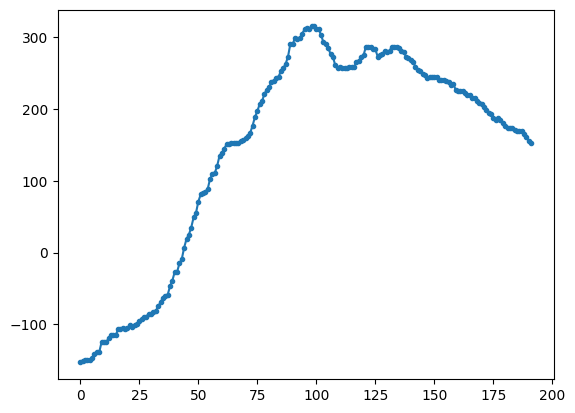

In [108]:
# plot
x = list(range(len(discrepency_at_i)))
plt.plot(x, discrepency_at_i, marker='.')

In [109]:
# find index of maximum value
# Hypothesis: this is the point where ChatGPT took over
discrepency_at_i.index(max(discrepency_at_i))

98

#### 1.4 SVD and Dimension Reduction

In [110]:
# compute AtA
At = A.T
AtA = At @ A  # matrix-multiplication of numpy
AtA

matrix([[30.,  2.,  2., ...,  2.,  1.,  0.],
        [ 2.,  9.,  2., ...,  0.,  1.,  0.],
        [ 2.,  2., 14., ...,  1.,  1.,  0.],
        ...,
        [ 2.,  0.,  1., ..., 16.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0., 17.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [111]:
# get eigenvalues sorted ascendingly
eigenvalues = np.linalg.eigvals(AtA)
# turn into singular values
singular_values = np.sqrt(eigenvalues)
# construct S (or Sigma)
myS = np.diag(singular_values)
singular_values[0:10]

array([15.67942887, 11.22376595, 10.30071569,  9.8333953 ,  9.1124641 ,
        9.01208809,  8.51358563,  8.2781031 ,  8.05947461,  7.9749155 ])

In [112]:
# get eigenvectors (sorted by eigenvalues)
eigenvectors = np.linalg.eig(AtA).eigenvectors
# construct Vt
myV = eigenvectors
myVt = myV.T
myVt

matrix([[ 5.85327502e-02,  2.01705599e-02,  4.64185441e-02, ...,
          1.45054537e-02,  3.79950241e-02,  0.00000000e+00],
        [-6.40258284e-02, -3.95357429e-02, -1.18340139e-01, ...,
         -1.59362659e-02, -1.25350152e-02,  0.00000000e+00],
        [ 4.62488365e-02,  2.77672604e-02,  1.61974612e-02, ...,
          2.08041720e-02, -1.95867194e-02,  0.00000000e+00],
        ...,
        [-1.98069335e-03,  1.88398033e-01,  1.48329401e-02, ...,
          6.14765304e-03, -3.60376443e-02,  0.00000000e+00],
        [ 6.51058200e-04,  1.66222243e-01,  1.55191802e-02, ...,
         -6.80588224e-02, -8.87338251e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [113]:
# compute U
myU = A @ myV @ np.linalg.inv(myS)
myU

LinAlgError: Singular matrix

In [114]:
print(np.linalg.matrix_rank(A))
print(np.shape(A))

191
(1107, 192)


In [115]:
print(np.linalg.matrix_rank(myS))
print(np.shape(myS))

191
(192, 192)


In [116]:
# compute U
myU = A @ myV @ np.linalg.pinv(myS)
myU

matrix([[ 0.01842194,  0.00849562,  0.0179347 , ..., -0.00445414,
          0.00999975,  0.        ],
        [ 0.0226497 , -0.00909633,  0.02040011, ...,  0.01027011,
         -0.0418471 ,  0.        ],
        [ 0.01458881, -0.0258958 , -0.06945861, ...,  0.00760931,
          0.00357772,  0.        ],
        ...,
        [ 0.01105378, -0.00985316,  0.00230336, ..., -0.04169452,
         -0.00060391,  0.        ],
        [ 0.01345382, -0.03497642,  0.022055  , ..., -0.00273485,
         -0.00102733,  0.        ],
        [ 0.0048013 , -0.0023397 ,  0.00474776, ..., -0.00551853,
          0.00651364,  0.        ]])

In [117]:
myA = myU @ myS @ myVt

In [118]:
# compare results to numpy.linalg.svd()
npU, npS, npVt = np.linalg.svd(A)
for i in range(len(npS)):
    print("npS: " + str(npS[i]) + ", sv: " + str(singular_values[i]))
# they differ in some places

npS: 15.679428871901488, sv: 15.679428871901496
npS: 11.22376594657025, sv: 11.223765946570264
npS: 10.300715689450929, sv: 10.30071568945095
npS: 9.833395304155154, sv: 9.833395304155177
npS: 9.112464104508723, sv: 9.1124641045087
npS: 9.012088087992858, sv: 9.012088087992892
npS: 8.513585633562096, sv: 8.513585633562121
npS: 8.278103100440427, sv: 8.27810310044044
npS: 8.05947460670247, sv: 8.059474606702453
npS: 7.974915499500587, sv: 7.974915499500601
npS: 7.807829091725228, sv: 7.807829091725228
npS: 7.61928408844277, sv: 7.619284088442765
npS: 7.428978997509551, sv: 7.4289789975095575
npS: 7.30248191592303, sv: 7.302481915923016
npS: 7.207728163287539, sv: 7.207728163287541
npS: 7.046966068935789, sv: 7.046966068935762
npS: 6.912022469740588, sv: 6.912022469740578
npS: 6.880077958377426, sv: 6.88007795837741
npS: 6.850095034030461, sv: 6.8500950340304545
npS: 6.683752552936589, sv: 6.683752552936582
npS: 6.596655608876757, sv: 6.596655608876734
npS: 6.520463982800592, sv: 6.52046

In [119]:
npVt

matrix([[-5.85327502e-02, -2.01705599e-02, -4.64185441e-02, ...,
         -1.45054537e-02, -3.79950241e-02,  0.00000000e+00],
        [ 6.40258284e-02,  3.95357429e-02,  1.18340139e-01, ...,
          1.59362659e-02,  1.25350152e-02,  0.00000000e+00],
        [-4.62488365e-02, -2.77672604e-02, -1.61974612e-02, ...,
         -2.08041720e-02,  1.95867194e-02,  0.00000000e+00],
        ...,
        [ 9.43022624e-03, -9.25333433e-03, -2.00031940e-02, ...,
         -8.69451850e-04, -3.98087355e-03,  0.00000000e+00],
        [-3.95260074e-03,  7.74649895e-03, -4.69772808e-02, ...,
          3.02823555e-03,  2.59442824e-03,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [120]:
npU

matrix([[-1.84219409e-02, -8.49561694e-03, -1.79346955e-02, ...,
          4.54711524e-03,  5.71598064e-05,  2.12832921e-03],
        [-2.26497033e-02,  9.09633391e-03, -2.04001103e-02, ...,
         -3.55806077e-03,  1.40000933e-03, -1.53996854e-02],
        [-1.45888106e-02,  2.58957978e-02,  6.94586095e-02, ...,
          5.64173336e-03, -6.45587893e-04, -7.57363681e-03],
        ...,
        [-1.10537775e-02,  9.85316180e-03, -2.30335825e-03, ...,
          6.59797949e-01,  4.10011847e-04,  1.30109751e-03],
        [-1.34538192e-02,  3.49764221e-02, -2.20550017e-02, ...,
         -9.51579287e-04,  9.80488007e-01, -3.39215909e-04],
        [-4.80130368e-03,  2.33969583e-03, -4.74775951e-03, ...,
         -7.21545188e-05, -3.89388905e-04,  9.75881936e-01]])

In [121]:
# compare Frobenius norms
print('A')
print(np.linalg.norm(myA, 'fro'))
print(np.linalg.norm(A, 'fro'))

print('\nV')
print(np.linalg.norm(myV, 'fro'))
print(np.linalg.norm(npVt, 'fro'))

print('\nU')
print(np.linalg.norm(myU, 'fro'))
print(np.linalg.norm(npU, 'fro'))  # => np.linalg.svd() does probably not use .pinv()

A
60.75360071633615
60.753600716336145

V
13.856406460551018
13.85640646055102

U
14.303804869744853
33.27160951922825


In [122]:
# going further use linalg.svd()
U, Sigma, Vt = np.linalg.svd(A)

In [123]:
k = 10  # Number of dimensions to keep
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
Vt_k = Vt[:k, :]

In [124]:
# re-create the appoximated term-sentence-matrix
A_k = U_k @ Sigma_k @ Vt_k
A_k

matrix([[ 0.01595231, -0.01956172,  0.00029973, ..., -0.01630601,
          0.02270508,  0.        ],
        [ 0.05568297,  0.04699269,  0.02804537, ...,  0.08568282,
          0.01637783,  0.        ],
        [-0.00987663, -0.01989377,  0.00714659, ..., -0.00809107,
          0.01709457,  0.        ],
        ...,
        [ 0.00732827,  0.00735849,  0.02753214, ...,  0.00072336,
          0.01978901,  0.        ],
        [ 0.06490259,  0.02238428,  0.05721864, ...,  0.0076131 ,
          0.00844101,  0.        ],
        [ 0.03708612,  0.01271314, -0.01398326, ...,  0.06481408,
          0.01154052,  0.        ]])

The rows of $A \in \mathbb{R}^{m \times n}$ represent the $m$ terms. \
The columns of $A$ represent the $n$ sentences. \
$U_k \in \mathbb{R}^{m \times k}$ maps the rows of $A_k$ (terms). \
$\Sigma_k \in \mathbb{R}^{k \times k}$ scales the values. \
$V^t \in \mathbb{R}^{k \times n}$ maps the columns of $A_k$ (sentences).

In [125]:
U_k[1]

matrix([[-0.0226497 ,  0.00909633, -0.02040011, -0.01747987,  0.02475355,
          0.08989716, -0.06182273, -0.03738773,  0.00348396,  0.05832825]])

In [126]:
print(np.shape(U_k))
np.array(U_k[1]).squeeze()

(1107, 10)


array([-0.0226497 ,  0.00909633, -0.02040011, -0.01747987,  0.02475355,
        0.08989716, -0.06182273, -0.03738773,  0.00348396,  0.05832825])

In [127]:
# calculating the similarity using cos()
def similarity(u, v):
    u = np.array(u).squeeze()
    v = np.array(v).squeeze()
    denominator = (np.linalg.norm(u) * np.linalg.norm(v))
    if denominator == 0:
        return 0
    return abs(np.dot(u, v)) / denominator

<BarContainer object of 191 artists>

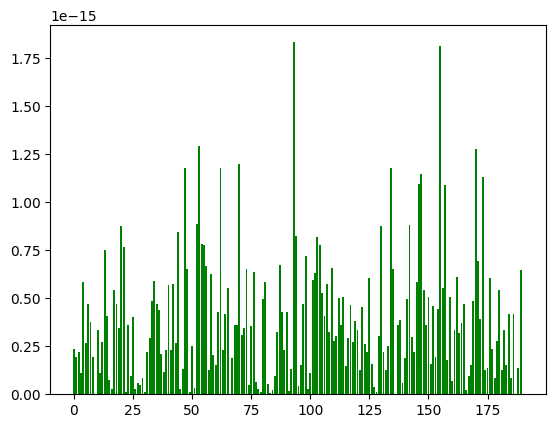

In [128]:
# plot similarity of sentences
similarities = [similarity(Vt[i], Vt[i + 1]) for i in range(Vt.shape[0] - 1)]
plt.bar(range(len(similarities)), similarities, color='green')